In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binance.client import Client
import datetime

In [23]:
# ===============================
# 1. Config
# ===============================
symbol = "BTCUSDT"
interval = Client.KLINE_INTERVAL_1HOUR  # 1H candles
lookback_months = 3


In [24]:
# ===============================
# 2. Fetch Binance Data
# ===============================
client = Client("", "")  # public klines don't need keys

end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=lookback_months*30)

klines = client.get_historical_klines(
    symbol,
    interval,
    start_str=start_time.strftime("%d %b %Y %H:%M:%S")
)

df = pd.DataFrame(klines, columns=[
    "Time","Open","High","Low","Close","Volume",
    "close_time","quote_asset_volume","number_of_trades",
    "taker_buy_base","taker_buy_quote","ignore"
])

# Clean + format
df["Time"] = pd.to_datetime(df["Time"], unit="ms")
df["Open"] = df["Open"].astype(float)
df["High"] = df["High"].astype(float)
df["Low"] = df["Low"].astype(float)
df["Close"] = df["Close"].astype(float)


In [25]:
# ===============================
# 3. MACD Calculation
# ===============================
df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = df["EMA12"] - df["EMA26"]
df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()
df["Histogram"] = df["MACD"] - df["Signal"]


In [26]:
# ===============================
# 4. Swing Highs and Lows
# ===============================
lookback = 5  # 2 candles before and after

def detect_swings(prices, highs, lows, lookback=5):
    labels = np.zeros(len(prices))
    for i in range(lookback, len(prices) - lookback):
        # Swing High
        if highs[i] == max(highs[i-lookback:i+lookback+1]):
            labels[i] = -1  # Downtrend reversal
        # Swing Low
        elif lows[i] == min(lows[i-lookback:i+lookback+1]):
            labels[i] = 1   # Uptrend reversal
        else:
            labels[i] = 0
    return labels

df["Label"] = detect_swings(df["Close"], df["High"], df["Low"], lookback=lookback)

In [27]:
df.head(20)

,Time,Open,High,Low,Close,Volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base,taker_buy_quote,ignore,EMA12,EMA26,MACD,Signal,Histogram,Label
0,2025-06-27 11:00:00,106995.33,107147.83,106921.66,106983.60,221.66755000,1751025599999,23719817.68811020,48153,118.60055000,12690081.38089600,0,106983.600000,106983.600000,0.000000,0.000000,0.000000,0.0
1,2025-06-27 12:00:00,106983.60,107200.00,106601.64,106692.90,489.40703000,1751029199999,52316156.48396080,101176,187.51853000,20047512.31065060,0,106938.876923,106962.066667,-23.189744,-4.637949,-18.551795,0.0
2,2025-06-27 13:00:00,106692.89,106982.40,106356.76,106820.99,613.57127000,1751032799999,65461028.57067920,170716,252.75383000,26973842.67975900,0,106920.740473,106951.616543,-30.876070,-9.885573,-20.990497,0.0
3,2025-06-27 14:00:00,106821.00,107105.43,106370.44,106557.79,2106.24243000,1751036399999,224667494.84162470,259116,674.20593000,71949927.53174980,0,106864.901939,106922.444207,-57.542268,-19.416912,-38.125356,0.0
4,2025-06-27 15:00:00,106557.79,107407.14,106485.37,107308.25,495.30793000,1751039999999,52973255.45450850,152376,261.72778000,28000575.96712040,0,106933.109333,106951.022414,-17.913081,-19.116146,1.203065,0.0
5,2025-06-27 16:00:00,107308.25,107709.22,107094.03,107480.10,678.72532000,1751043599999,72926351.29335010,155919,370.75350000,39842745.19008300,0,107017.261743,106990.213346,27.048397,-9.883237,36.931634,-1.0
6,2025-06-27 17:00:00,107480.10,107497.16,106477.34,106875.75,501.23090000,1751047199999,53585068.60325920,147434,214.88595000,22964452.01245490,0,106995.490706,106981.734580,13.756126,-5.155364,18.911491,0.0
7,2025-06-27 18:00:00,106875.75,107000.00,106446.45,106704.60,440.83658000,1751050799999,47022501.97768680,151731,176.64076000,18843433.90533020,0,106950.738290,106961.206092,-10.467803,-6.217852,-4.249951,0.0
8,2025-06-27 19:00:00,106704.60,107020.66,106594.10,106801.02,366.69076000,1751054399999,39170807.00769470,98214,168.23444000,17972766.80775490,0,106927.704707,106949.340456,-21.635749,-9.301431,-12.334318,0.0
9,2025-06-27 20:00:00,106801.02,107130.36,106794.33,107119.50,254.52948000,1751057999999,27239961.89608980,69162,121.63172000,13016229.39067200,0,106957.211675,106961.944866,-4.733192,-8.387783,3.654592,0.0


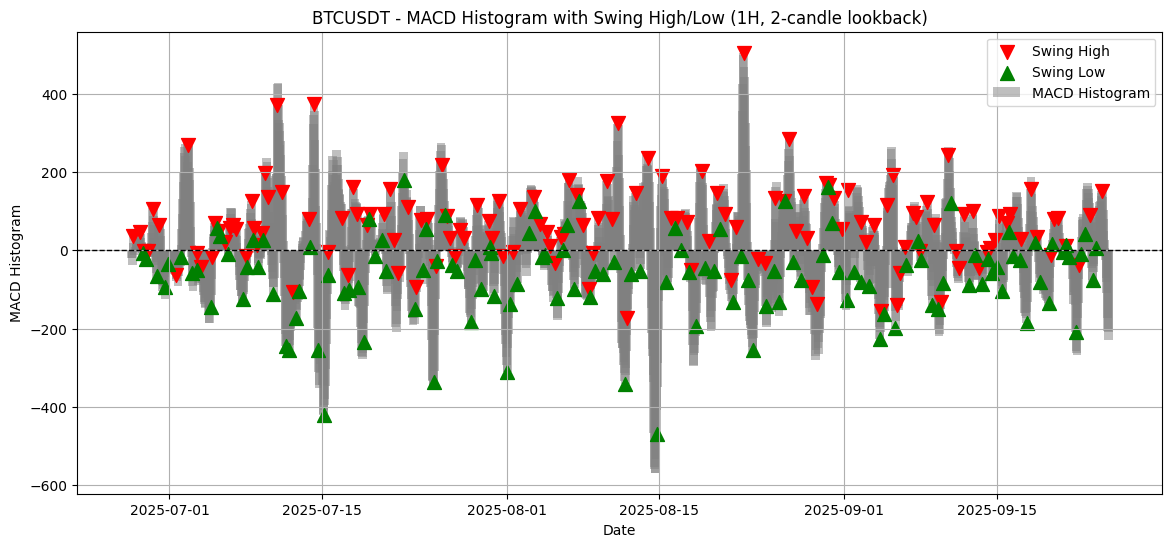

In [28]:
# ===============================
# 5. Plot MACD Histogram + Reversals
# ===============================
plt.figure(figsize=(14,6))

# MACD histogram
plt.bar(df["Time"], df["Histogram"], label="MACD Histogram", color="gray", alpha=0.5)

# Swing Highs
plt.scatter(df.loc[df["Label"]==-1, "Time"], 
            df.loc[df["Label"]==-1, "Histogram"], 
            color="red", marker="v", s=100, label="Swing High")

# Swing Lows
plt.scatter(df.loc[df["Label"]==1, "Time"], 
            df.loc[df["Label"]==1, "Histogram"], 
            color="green", marker="^", s=100, label="Swing Low")

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.title(f"{symbol} - MACD Histogram with Swing High/Low (1H, 2-candle lookback)")
plt.xlabel("Date")
plt.ylabel("MACD Histogram")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

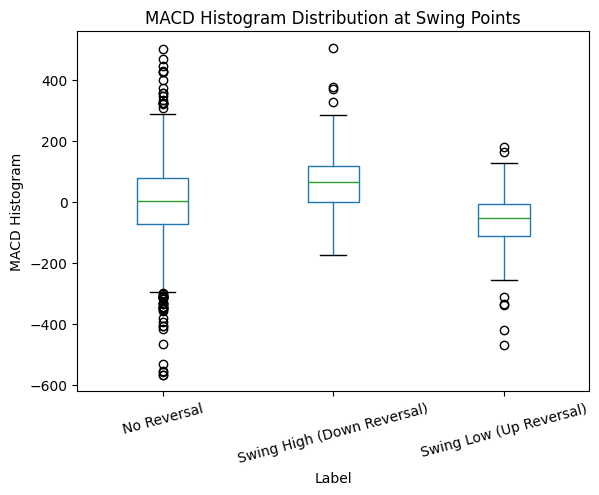

In [29]:
# ===============================
# 6. Boxplot of Histogram vs Labels
# ===============================
plt.figure(figsize=(8,6))

df_box = df[["Histogram", "Label"]].copy()
df_box["Label"] = df_box["Label"].map({
    -1: "Swing High (Down Reversal)",
     1: "Swing Low (Up Reversal)",
     0: "No Reversal"
})

df_box.boxplot(column="Histogram", by="Label", grid=False)

plt.title("MACD Histogram Distribution at Swing Points")
plt.suptitle("")  # remove auto title
plt.ylabel("MACD Histogram")
plt.xticks(rotation=15)
plt.show()
